# Empirical mode decomposition (EMD) example
## Five components, amplitude-modulated
In this example we generate a signal consisting of five amplitude-modulated components. We go through the EMD sifting process step by step and visualise the results. We also look at the full decomposition and investigate the errors made.
### Produces Figures 6-15
This corresponds to chapter 3 and the first figure in chapter 4.

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import scipy
import PyEMD

### Generate Data

In [2]:
np.random.seed(1)
nS = 1                                 # number of seconds
Fs = 4800/4                            # sample rate (Hz)
t = np.arange(0,nS,1/Fs)               # time
f = np.array([4, 8, 23, 55, 120])      # frequencies
nT = len(t)                            # number of time steps
nF = len(f)                            # number of frequency components
p = np.random.uniform(low=0.0,         # phase offsets
                      high=2*np.pi,
                      size=len(f)) 
w = 1000                               # window for moving average, amplitude smoothing
noise_mean = 0.0
noise_std = 0.00

#b = np.array([1., 1., 1., 1., 1.])    # base amplitude
b = np.array([0.8, 1., 0.6, 0.4, 0.3]) # base amplitude

# amplitude of components
amp_flag = 'peri' 
a = np.zeros((nF, nT))
if amp_flag == 'const':          # constant amplitude
    a = np.transpose(np.tile(b, (nT, 1))) 
elif amp_flag == 'vari':         # variable amplitude
    a = np.random.rand(nF, nT)
    for i in range(nF):
        a[i, :] = b[i] * np.convolve(a[i,:], np.ones(int(w)), 'same') / w
elif amp_flag == 'peri':         # periodic amplitude
    for i in range(nF):
        a[i, :] = b[i] * np.sin(2 * np.pi * f[i]/10 * t)

# define components, C
C = np.ndarray(shape=(nF,nT))
for i in range(nF):
    C[i, :] = a[i, :] * np.sin(2*np.pi*f[i]*t + p[i])

# add noise
noise = np.random.normal(loc=noise_mean, scale=noise_std, size=(nT,))
x = np.sum(C,0) + noise

### Phase offsets

In [3]:
np.round(p, 5)

array([2.62023e+00, 4.52593e+00, 7.20000e-04, 1.89961e+00, 9.22090e-01])

In [10]:
from fractions import Fraction

p_round = np.zeros(nF, dtype=Fraction)
for i in range(0,nF):
    p_round[i] = Fraction(p[i] / np.pi).limit_denominator(max_denominator=10)
    print(str(p_round[i]))

5/6
13/9
0
3/5
3/10


### Visualize signal and components

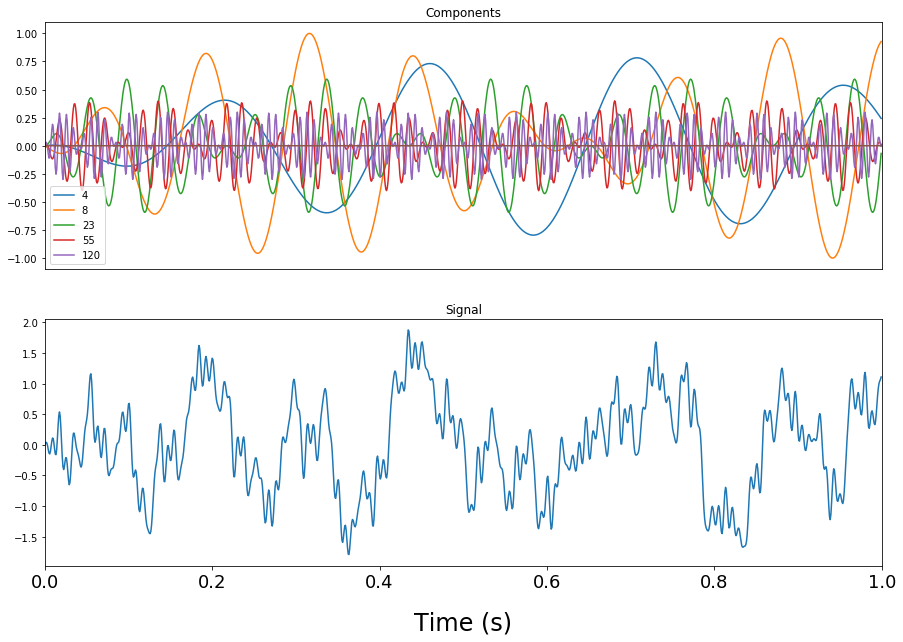

In [4]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
for j in range(nF):
    plt.plot(t, C[j,:], label=str(f[j]))

plt.plot(t, noise)
plt.title('Components')
plt.legend()
plt.xlim(0, nS)
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(t,x)
plt.title('Signal')
plt.xlim(0, nS)
plt.xticks(fontsize=18)

plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/ex_emd_signal.pdf', bbox_inches = "tight")
plt.show()

### Compute analytic signal and instantaneous frequency

In [5]:
analytic_signal = scipy.signal.hilbert(C)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * Fs)

/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:1616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


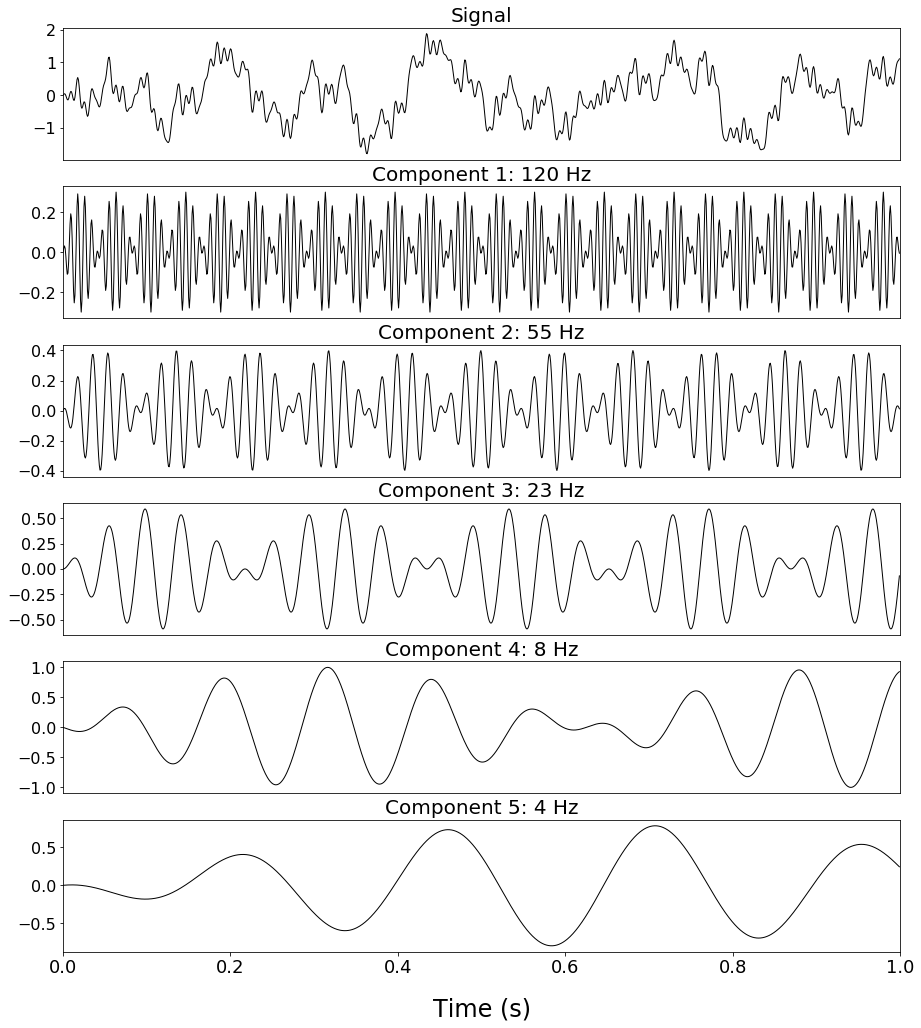

In [6]:
plt.figure(figsize=(15,17))

plt.subplot(nF+1,1,1)
plt.title('Signal', fontsize=20)
plt.plot(t, x, linestyle='-', linewidth='1.',color='black')
plt.xlim(0, nS)
plt.xticks([])
plt.yticks(fontsize=16)

for j in range(nF):
    plt.subplot(nF+1, 1, j+2)
    plt.title('Component ' + str(j+1) + ': ' + str(f[-(j+1)]) + ' Hz', fontsize=20)
    plt.plot(t, C[-(j+1),:], 'k', label=str(f[-(j+1)])+' Hz',  linestyle='-', linewidth='1.',color='black')
    #plt.legend(loc='upper right', fontsize=18, handlelength = 0)
    plt.xlim(0, nS)
    plt.yticks(fontsize=16)
    if j < nF-1:
        plt.xticks([])

plt.xticks(fontsize=18)
plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/1_ex_emd_signal.pdf', bbox_inches = "tight")
plt.show()

## EMD instance

In [7]:
emd = PyEMD.EMD()

-------------------------------------------
## SIFTING PROCESS
-------------------------------------------

Here we go through the sifting process for two iterations to visualise the steps. We don't concern ourselves with the boundaries to keep things simple. That is, we skip the step of extrapolating the extrema at the boundary and so in the exampls on each sifting iteration we lose data points.

In [8]:
# we choose a short time window to see things up close
t1 = 0.25
t2 = 0.75

## ITERATION 1.

## Step 1.1: Find extrema

In [9]:
local_max_pos, local_max_val, local_min_pos, local_min_val = emd.find_extrema(t, x)[0:4]

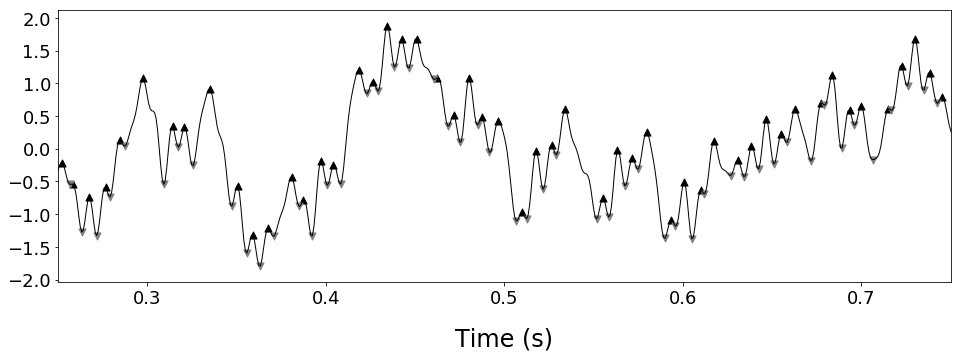

In [10]:
plt.figure(figsize=(16,5))
plt.plot(t, x, linestyle='-', linewidth='1.',color='black')
plt.scatter(local_max_pos, local_max_val, s=50, marker='^', color='black')
plt.scatter(local_min_pos, local_min_val, s=50, marker='v', color='grey')
plt.xlim(t1, t2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/2_ex_emd_extrema.pdf', bbox_inches = "tight")
plt.show()

## Step 2.1: Compute envelopes

In [11]:
upper_env_t, upper_env_val = emd.spline_points(t, np.array([local_max_pos, local_max_val]))
lower_env_t, lower_env_val = emd.spline_points(t, np.array([local_min_pos, local_min_val]))

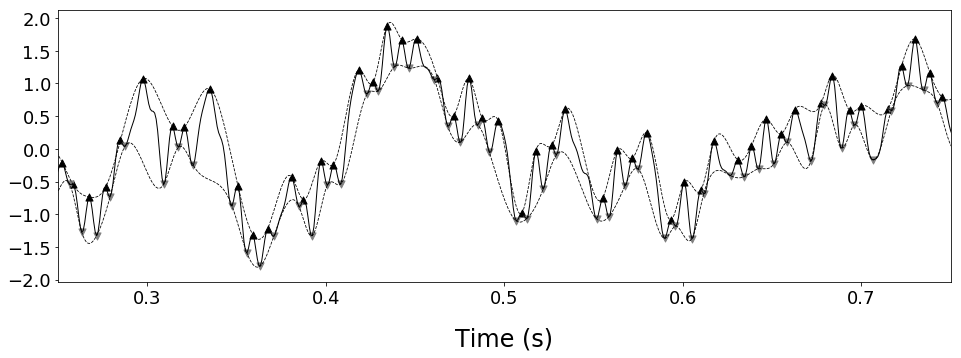

In [12]:
plt.figure(figsize=(16,5))
plt.plot(t, x, linestyle='-', linewidth='1.',color='black')
plt.scatter(local_max_pos, local_max_val, s=50, marker='^', color='black')
plt.scatter(local_min_pos, local_min_val, s=50, marker='v', color='grey')
plt.plot(upper_env_t, upper_env_val, linestyle='--', linewidth='.8',color='black')
plt.plot(lower_env_t, lower_env_val, linestyle='--', linewidth='.8',color='black')
plt.xlim(t1, t2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/3_ex_emd_envelopes.pdf', bbox_inches = "tight")
plt.show()

## Step 3.1: Compute mean of upper and lower envelopes

In [13]:
# first find the intersection of the time vectors for upper and lower envelope
t_env, ind_u, ind_l = np.intersect1d(upper_env_t, lower_env_t, return_indices=True)

# compute the mean for shared time points
mean_env = np.mean(np.array([upper_env_val[ind_u], lower_env_val[ind_l]]), axis=0)

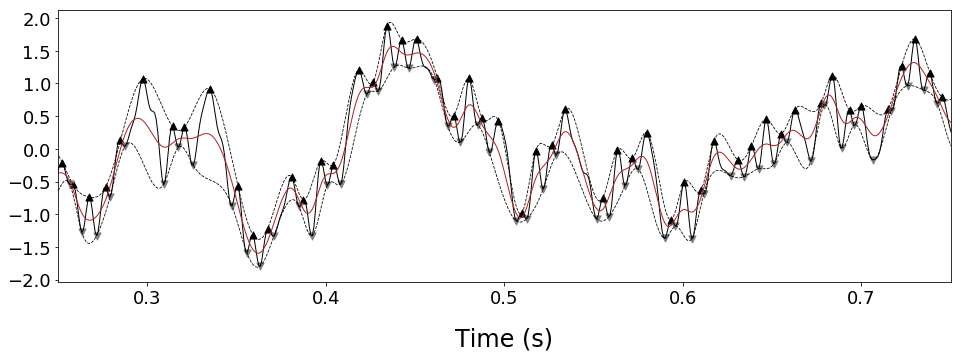

In [14]:
plt.figure(figsize=(16,5))
plt.plot(t, x, linestyle='-', linewidth='1.',color='black')
plt.scatter(local_max_pos, local_max_val, s=50, marker='^', color='black')
plt.scatter(local_min_pos, local_min_val, s=50, marker='v', color='grey')
plt.plot(upper_env_t, upper_env_val, linestyle='--', linewidth='.8',color='black')
plt.plot(lower_env_t, lower_env_val, linestyle='--', linewidth='.8',color='black')
plt.plot(t_env, mean_env, linestyle='-', linewidth='1',color='firebrick')
plt.xlim(t1, t2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/4_ex_emd_mean.pdf', bbox_inches = "tight")
plt.show()

## Step 4.1: Subtract envelope mean from signal

In [15]:
# first find the intersection of the time vectors for the signal and the computed envelope mean
t_sift, ind_t, ind_t_env = np.intersect1d(t, t_env, return_indices=True)
x_sift = x[ind_t] - mean_env

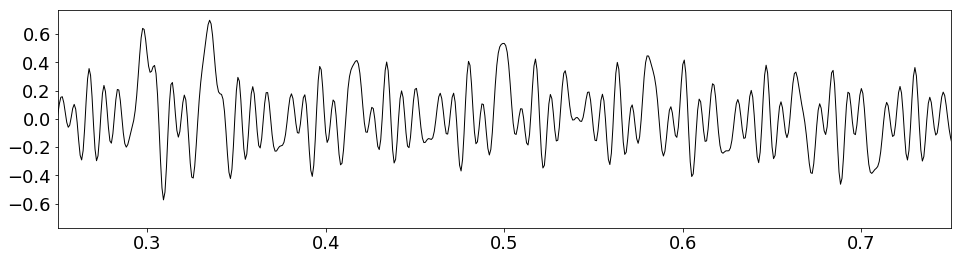

In [16]:
plt.figure(figsize=(16,4))
plt.plot(t_sift, x_sift, linestyle='-', linewidth='1.',color='black')
plt.xlim(t1, t2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/5_ex_emd_sift.pdf', bbox_inches = "tight")
plt.show()

## Step 5.1: Test whether IMF criteria met

In [17]:
emd.check_imf(x_sift, x[ind_t_env], local_max_val, local_min_val)

False

### Plot power spectrum via Welch **LOG
We take a look at the power spectrum after the first iteration. Notice it contains multiple frequencies.

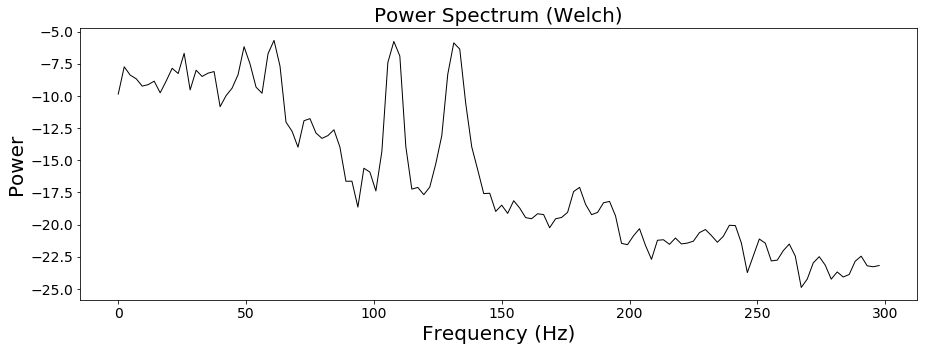

In [18]:
cut_off = 300
power, freqs = mlab.psd(x_sift, NFFT=512, Fs=Fs)
plt.figure(figsize=(15,5))
plt.plot(freqs[freqs<cut_off], np.log(power[freqs<cut_off]), linewidth=1., color='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Power Spectrum (Welch)', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Power', fontsize=20)
plt.show()

## ITERATION 2.

## Step 1.2: Find extrema

In [19]:
local_max_pos, local_max_val, local_min_pos, local_min_val = emd.find_extrema(t_sift, x_sift)[0:4]

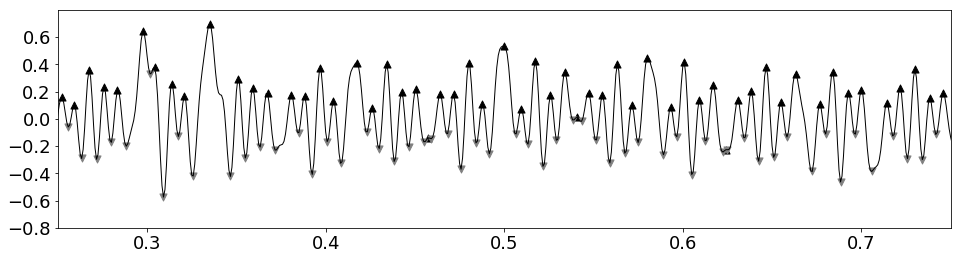

In [20]:
plt.figure(figsize=(16,4))
plt.plot(t_sift, x_sift, linestyle='-', linewidth='1.',color='black')
plt.scatter(local_max_pos, local_max_val, s=50, marker='^', color='black')
plt.scatter(local_min_pos, local_min_val, s=50, marker='v', color='grey')
plt.xlim(t1, t2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/6_ex_emd_extrema_sift2.pdf', bbox_inches = "tight")
plt.show()

## Step 2.2: Compute envelopes

In [21]:
upper_env_t, upper_env_val = emd.spline_points(t_sift, np.array([local_max_pos, local_max_val]))
lower_env_t, lower_env_val = emd.spline_points(t_sift, np.array([local_min_pos, local_min_val]))

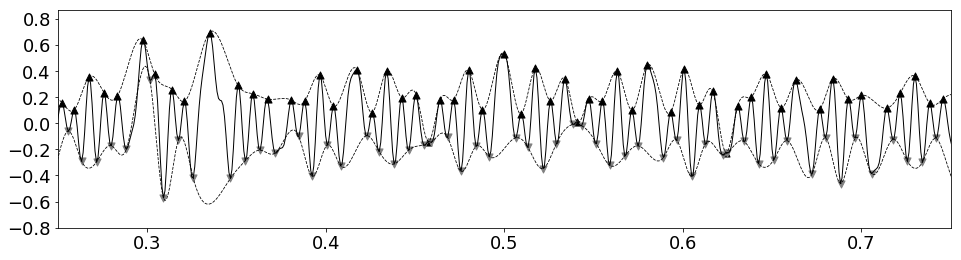

In [22]:
plt.figure(figsize=(16,4))
plt.plot(t_sift, x_sift, linestyle='-', linewidth='1.',color='black')
plt.scatter(local_max_pos, local_max_val, s=50, marker='^', color='black')
plt.scatter(local_min_pos, local_min_val, s=50, marker='v', color='grey')
plt.plot(upper_env_t, upper_env_val, linestyle='--', linewidth='.8',color='black')
plt.plot(lower_env_t, lower_env_val, linestyle='--', linewidth='.8',color='black')
plt.xlim(t1, t2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/7_ex_emd_envelopes_sift2.pdf', bbox_inches = "tight")
plt.show()

## Step 3.2: Compute mean of upper and lower envelopes

In [23]:
# first find the intersection of the time vectors for upper and lower envelope
t_env, ind_u, ind_l = np.intersect1d(upper_env_t, lower_env_t, return_indices=True)

# compute the mean for shared time points
mean_env = np.mean(np.array([upper_env_val[ind_u], lower_env_val[ind_l]]), axis=0)

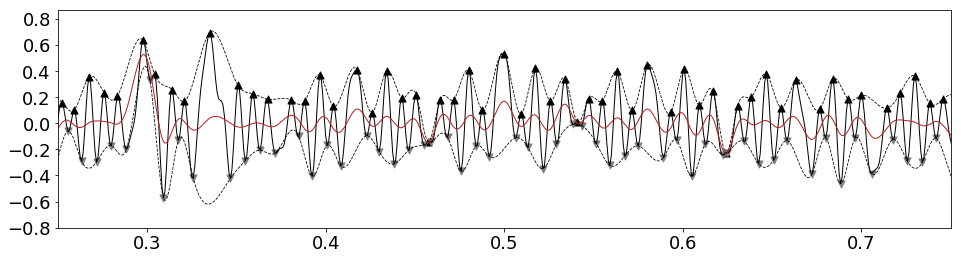

In [24]:
plt.figure(figsize=(16,4))
plt.plot(t_sift, x_sift, linestyle='-', linewidth='1.',color='black')
plt.scatter(local_max_pos, local_max_val, s=50, marker='^', color='black')
plt.scatter(local_min_pos, local_min_val, s=50, marker='v', color='grey')
plt.plot(upper_env_t, upper_env_val, linestyle='--', linewidth='.8',color='black')
plt.plot(lower_env_t, lower_env_val, linestyle='--', linewidth='.8',color='black')
plt.plot(t_env, mean_env, linestyle='-', linewidth='1',color='firebrick')
plt.xlim(t1, t2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/8_ex_emd_mean_sift2.pdf', bbox_inches = "tight")
plt.show()

## Step 4.2: Subtract envelope mean from signal

In [25]:
# first find the intersection of the time vectors for the signal and the computed envelope mean
t_sift2, ind_t, ind_t_env = np.intersect1d(t_sift, t_env, return_indices=True)
x_sift2 = x_sift[ind_t] - mean_env

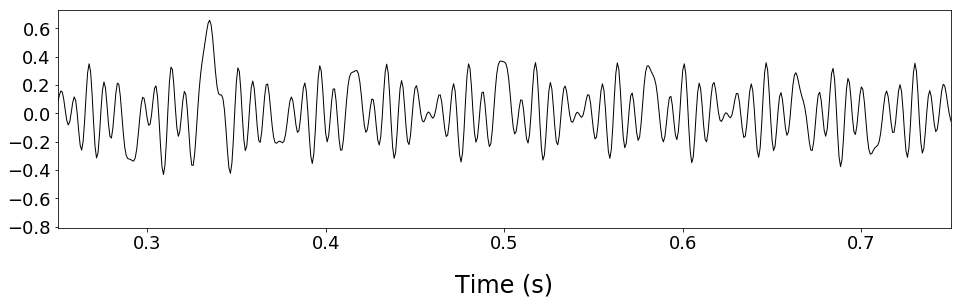

In [26]:
plt.figure(figsize=(16,4))
plt.plot(t_sift2, x_sift2, linestyle='-', linewidth='1.',color='black')
plt.xlim(t1, t2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/9_ex_emd_sift_sift2.pdf', bbox_inches = "tight")
plt.show()

## Step 5.2: Test whether IMF criteria met

In [27]:
emd.check_imf(x_sift2, x_sift[ind_t_env], local_max_val, local_min_val)

False

### Plot power spectrum via Welch **LOG

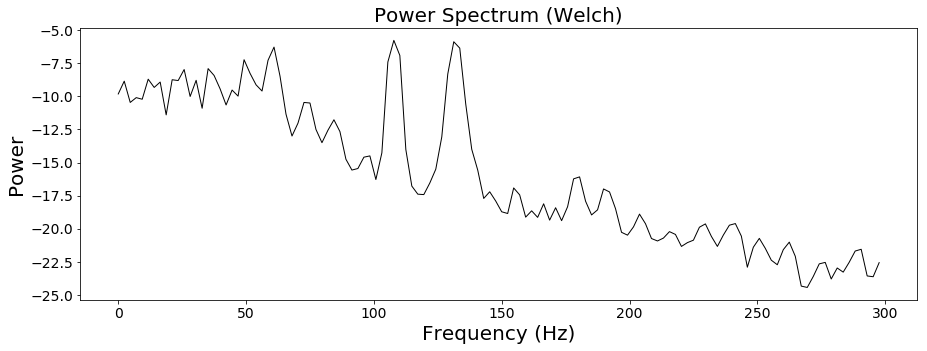

In [28]:
cut_off = 300
power, freqs = mlab.psd(x_sift2, NFFT=512, Fs=Fs)
plt.figure(figsize=(15,5))
plt.plot(freqs[freqs<cut_off], np.log(power[freqs<cut_off]), linewidth=1., color='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Power Spectrum (Welch)', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Power', fontsize=20)
plt.show()

## And continue...
This process continues until the IMF criteria are met.

### Extract IMFs

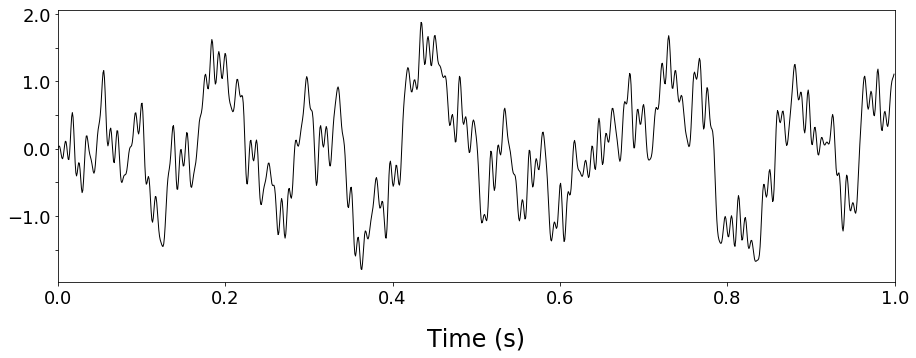

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, x, linestyle='-', linewidth='1.',color='black')
plt.xlim(0, nS)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Time (s)', fontsize=24, labelpad=20)

every_nth = 2
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

In [30]:
# Extract imfs and residue
emd = PyEMD.EMD()
emd.emd(x)
imfs, res = emd.get_imfs_and_residue()
nIMF = imfs.shape[0]

### Compute analytic signal and instantaneous frequency

In [31]:
analytic_signal = np.zeros(shape=(nIMF, nT), dtype=np.complex_)
for k in range(nIMF):
    analytic_signal[k, :] = scipy.signal.hilbert(imfs[k, :])
    
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * Fs)

### Print median frequencies of IMFs

In [32]:
np.set_printoptions(suppress=True)
f_m = np.round(np.median(instantaneous_frequency,1),2)
for i in range(len(f_m)):
    print('IMF ' + str(i+1) + ': ' + str(f_m[i]))

IMF 1: 120.77
IMF 2: 55.85
IMF 3: 23.21
IMF 4: 8.19
IMF 5: 3.99
IMF 6: 1.58
IMF 7: 0.79


### Plot data and IMFs

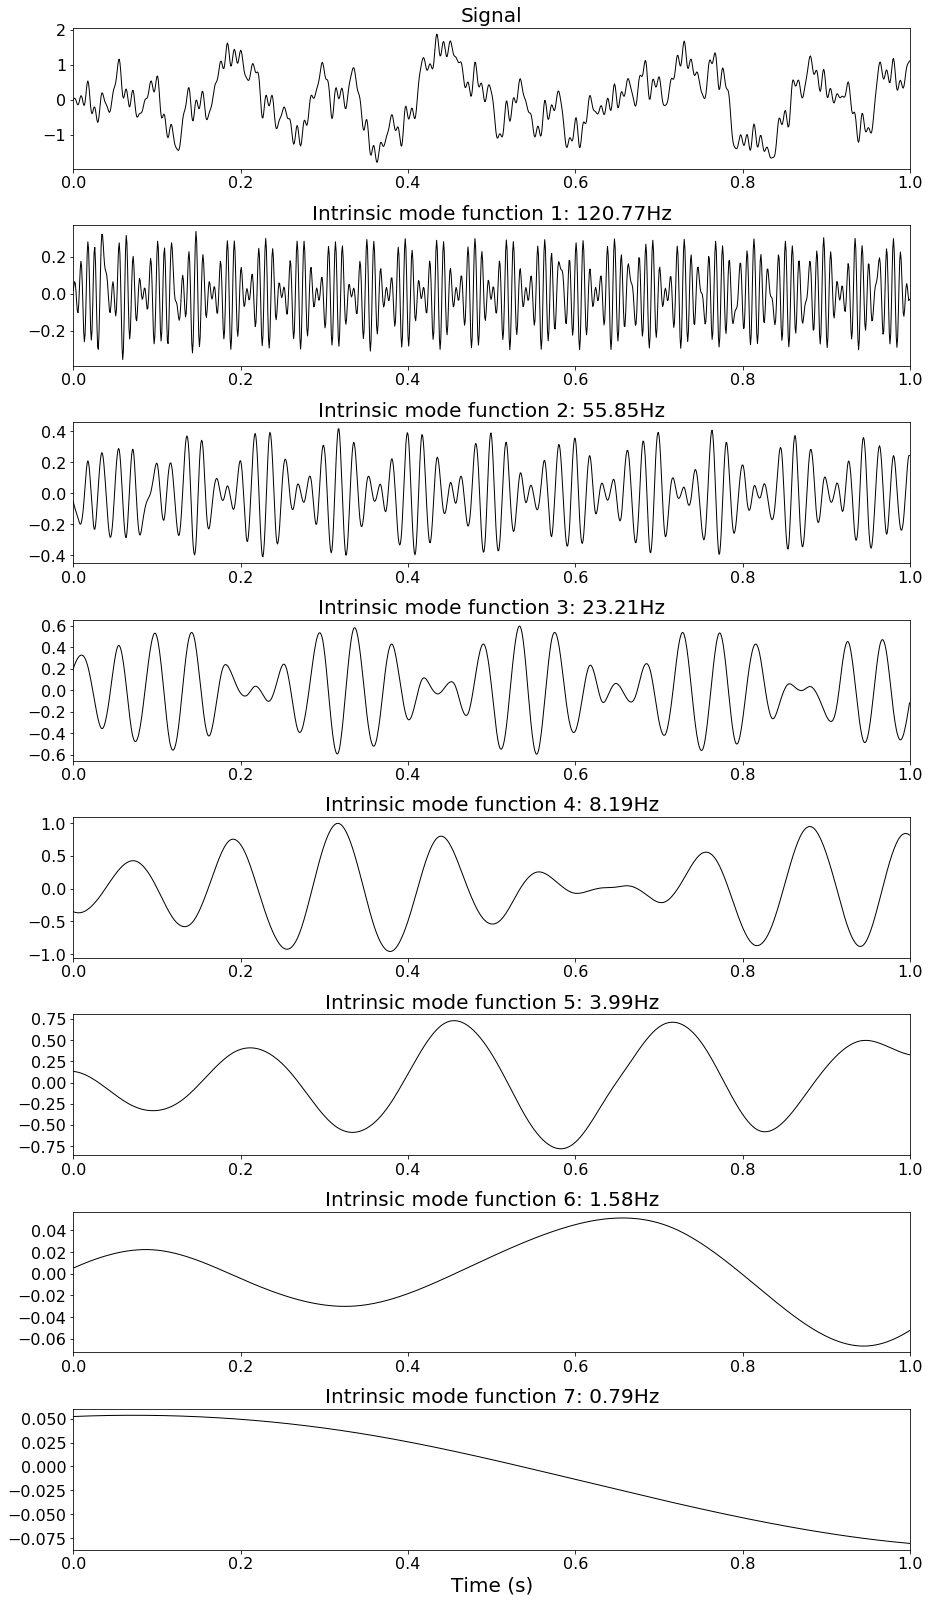

In [45]:
fig, ax = plt.subplots(figsize=(15,4*len(f_m)))
plt.subplot(nIMF+1,1,1)
plt.plot(t, x, linewidth=1, color='black')
plt.xlim(0, nS)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylabel('Signal Strength', fontsize=18)
plt.title('Signal', fontsize=20)
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(t, imfs[ii-1,:], linewidth=1, color='black')
    plt.xlim(0, nS)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.ylabel('Signal Strength', fontsize=18)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    if ii == nIMF:
        plt.xlabel('Time (s)', fontsize=20)

fig.subplots_adjust(hspace=0.4)

plt.savefig('plots/10_ex_emd_IMFs.pdf', bbox_inches = "tight")
plt.show()

### Plot power spectrum of IMF1 via Welch **LOG

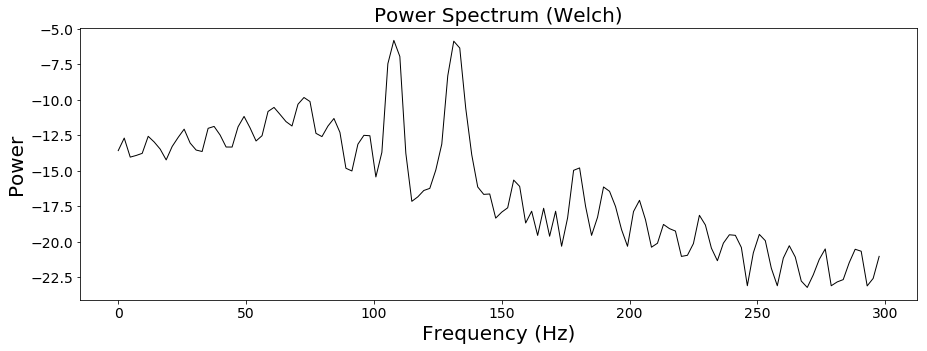

In [34]:
cut_off = 300
power, freqs = mlab.psd(imfs[0,:], NFFT=512, Fs=Fs)
plt.figure(figsize=(15,5))
plt.plot(freqs[freqs<cut_off], np.log(power[freqs<cut_off]), linewidth=1., color='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Power Spectrum (Welch)', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Power', fontsize=20)
plt.show()

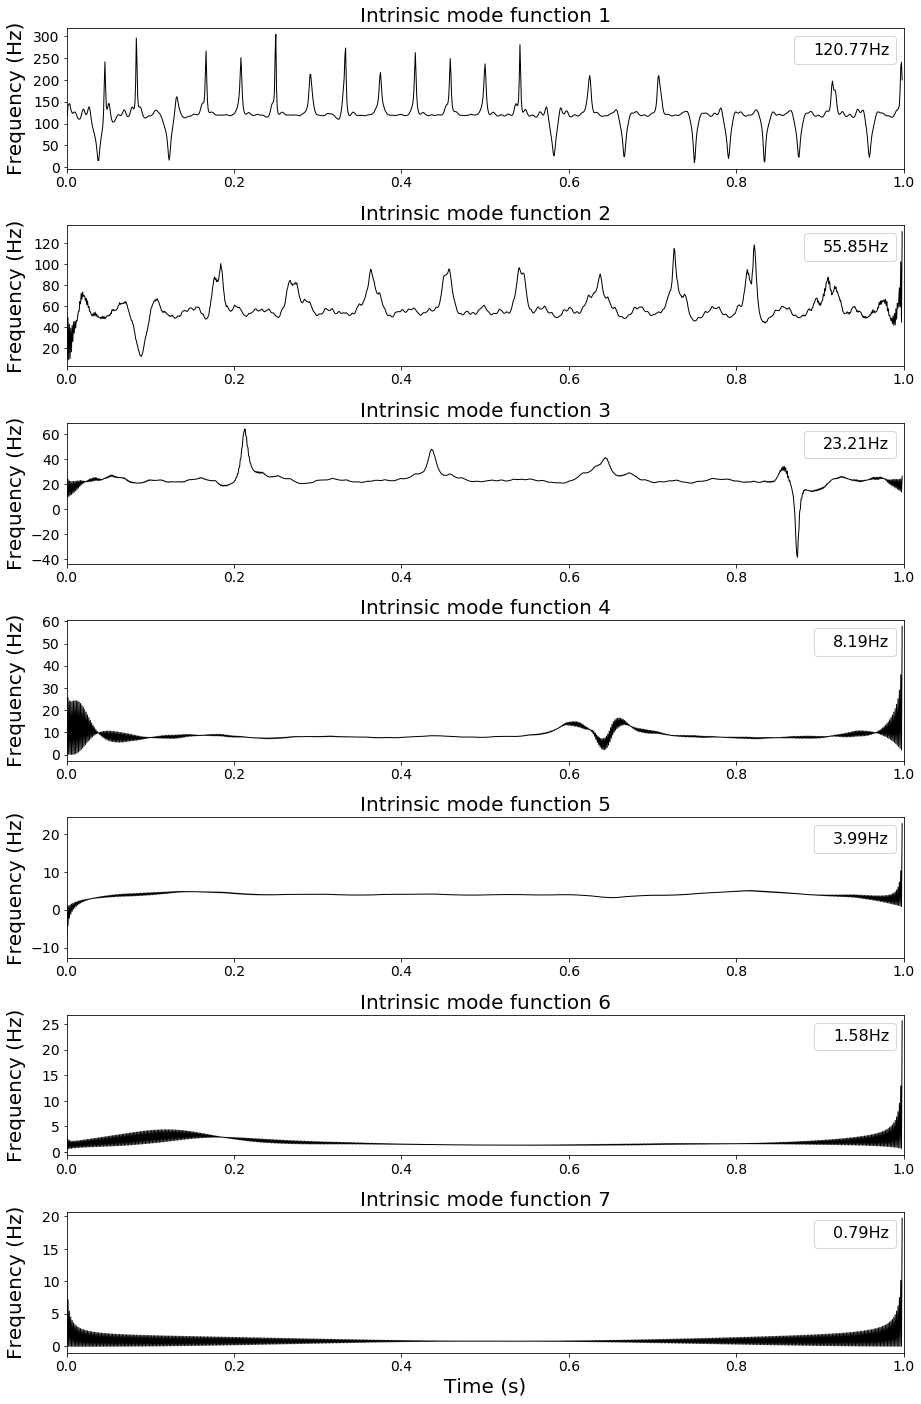

In [46]:
fig, ax = plt.subplots(figsize=(15,4*len(f_m)))
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(t[0:-1], instantaneous_frequency[ii-1,:], linewidth=1, color='black', label=str(f_m[ii-1]) + 'Hz')
    plt.xlim(0,nS)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii), fontsize=20)# + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    plt.legend(loc='upper right', handlelength=0, fontsize=16)
    plt.ylabel('Frequency (Hz)', fontsize=20)
    if ii == nIMF:
        plt.xlabel('Time (s)', fontsize=20)

fig.subplots_adjust(hspace=0.4)
fig.align_ylabels()

plt.savefig('plots/11_ex_emd_IMFs_inst_freq.pdf', bbox_inches = "tight")
plt.show()

### Error

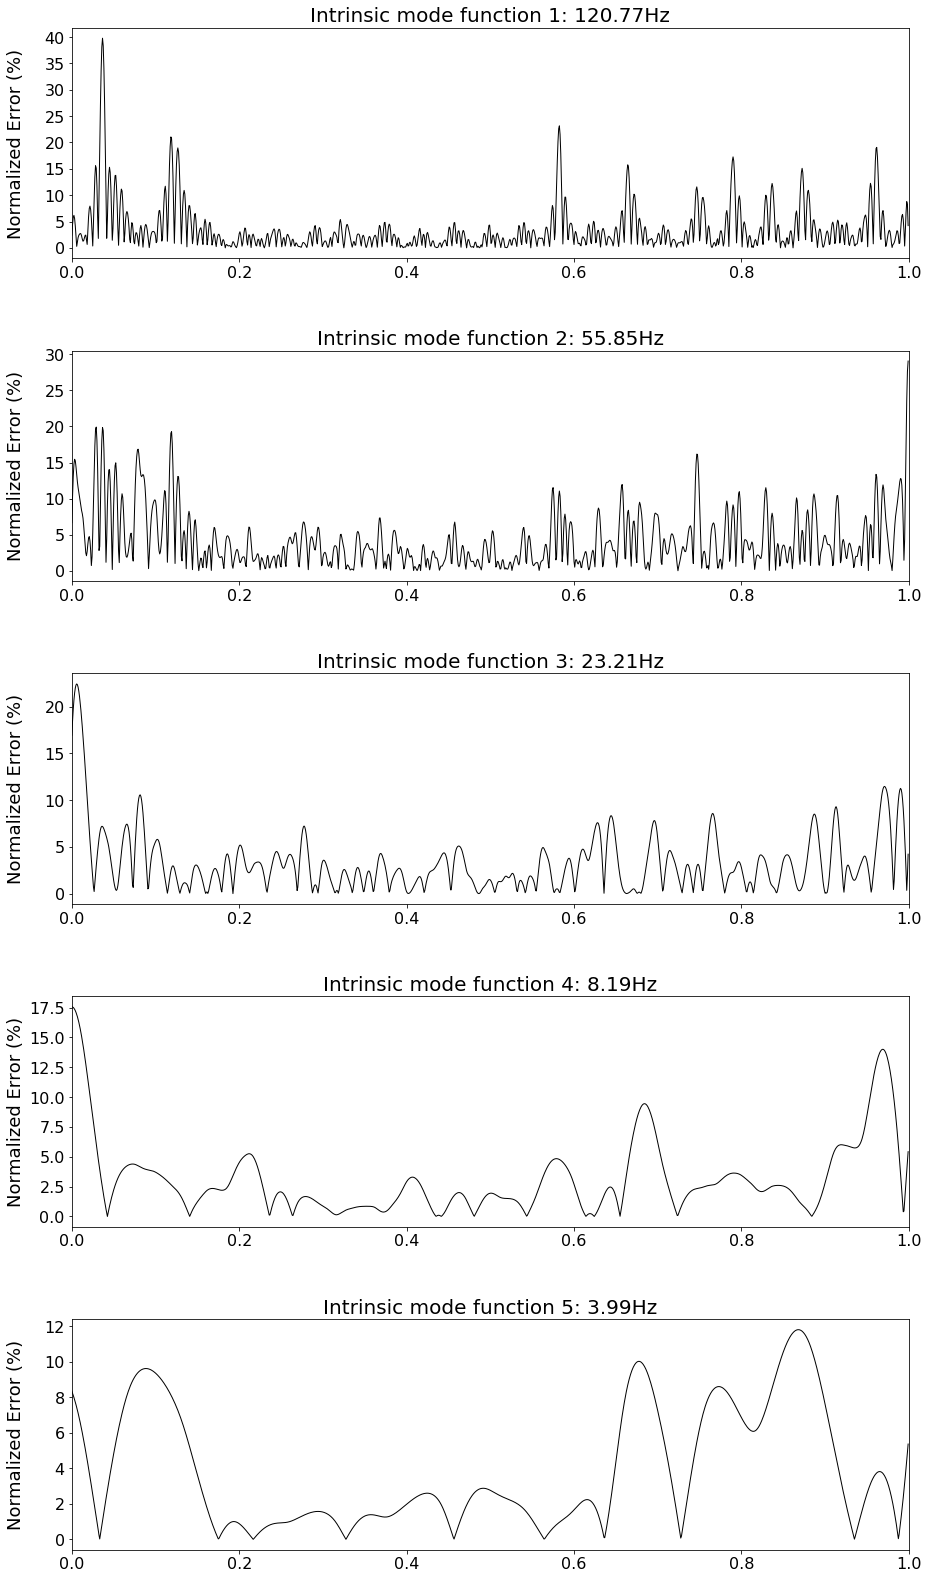

In [47]:
fig, ax = plt.subplots(figsize=(15,4*len(f_m)))
for ii in range(1,nF+1):
    plt.subplot(nF,1,ii)
    abs_err_ptwise = np.abs(C[-ii,:] - imfs[ii-1,:])                    # absolute pointwise error
    signal_range = np.abs(np.max(C[-ii,:]) + np.abs(np.min(C[-ii,:])))  # range, absolute max - absolute min
    rel_err = 100*abs_err_ptwise/signal_range                           # relative percent error
    plt.plot(t, rel_err, linewidth=1, color='black')
    plt.xlim(0, nS)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('Normalized Error (%)', fontsize=18)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    if ii == nIMF:
        plt.xlabel('Time (s)', fontsize=20)

fig.subplots_adjust(hspace=0.4)
fig.align_ylabels()

plt.savefig('plots/12_ex_emd_normalized_error.pdf', bbox_inches = "tight")
plt.show()

### Example of component vs. IMF
We can see the error being made.

(0.0, 0.08333333333333333)

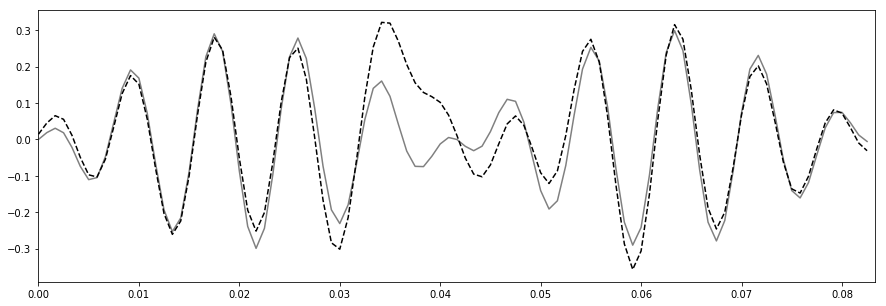

In [37]:
s1 = 0 
s2 = 100
plt.figure(figsize=(15,5))
plt.plot(t[s1:s2], C[4, s1:s2], color='grey')
plt.plot(t[s1:s2], imfs[0, s1:s2], linestyle='--', color='black')
plt.xlim(s1/Fs, s2/Fs)

### Amplitude ratio between first and second component

/Users/Andrew/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


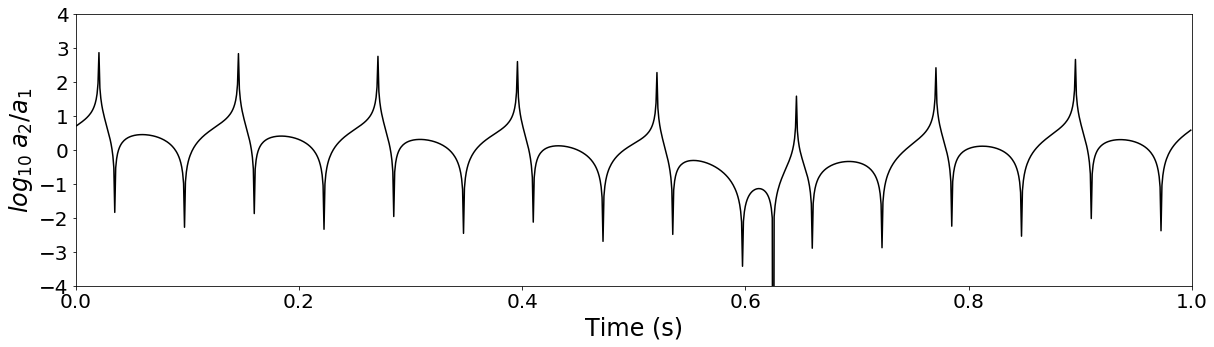

In [38]:
amp_ratio = np.abs(C[1,:]) / np.abs(C[0,:])

plt.figure(figsize=(20,5))
plt.plot(t, np.log10(amp_ratio), linewidth=1.5, color='black')
plt.xlim(0, nS)
plt.ylim(-4, 4)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time (s)', fontsize=24)
plt.ylabel('$log_{10} \; a_2 / a_1 $', fontsize=24)

plt.savefig('plots/ch5-1-1_mode_mixing_C1-vs-C2.pdf', bbox_inches = "tight")

plt.show()